<a class="anchor" id="0.0"></a>
# **HVAC-Klassifizierung**

###### Matrikelnummern: 68079, 67628

<a class="anchor" id="0"></a>
# **Inhaltsverzeichnis**
1.	[Vorverarbeitung](#1.)
 - 1.1.	[Ausreißerentfernung](#1.1.)
 - 1.2.	[Funktionen fürs Training](#1.2.)
    
2.	[Simple Modelle](#2.)
 - 2.1.	[Logistische Regression Einfach](#2.1.)
 - 2.1.1.	[Verbesserung der LR mit Hyperparametertuning](#2.1.1.)
 - 2.2.	[Decision Tree Einfach](#2.2.)
 - 2.2.1.	[Verbesserung des DT mit Hyperparametertuning](#2.2.1.)
 - 2.3.	[Random Forest Einfach](#2.3.)
 - 2.3.1.	[Verbesserung des RF mit Hyperparametertuning](#2.3.1.)
 - 2.4.	[SVC Einfach](#2.4.)
 - 2.4.1.	[Verbesserung des SVC mit Hyperparametertuning](#2.4.1.)
 
3.	[Modelle mit Arbeitszeit als Feature](#3.)
 - 3.1.	[Logistische Regression](#3.1.)
 - 3.2.	[Decision Tree](#3.2.)
 - 3.3.	[Random Forest](#3.3.)
 - 3.4.	[SVC](#3.4.)
4.	[Analyse](#4.)
 - 4.1.	[ROC-Kurve](#4.1.)
 - 4.1.1.	[Gemittelte Vorhersage aller Modelle auf den unbekannten Testdaten](#4.1.1.)
 - 4.2. [Kostenrechnung](#4.2.)
 - 4.2.1.	[Berechnung der Kosten der einfachen Modelle](#4.2.1.)
 - 4.2.2.	[Berechnung der Kosten der Modelle mit Arbeitszeit](#4.2.2.)
 - 4.2.3.	[Optimierung der Kosten](#4.2.3.)

## **1. Vorverarbeitung** <a class="anchor" id="1."></a>

[Inhaltsverzeichnis](#0)

In [1]:
import pandas as pd
import plotly.express as px
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv",index_col=0)
df.Datum = pd.to_datetime(df["Datum"])
df.set_index(df["Datum"],inplace=True)

#Annahme: Regelmäßige Zeiten machen den Großteil der Fälle aus, wenn z.B. nachts jemand da ist ist manuelles einschalten zumutbar. 
#Eventuell könnte die Automatik auch nur in der Arbeitszeit aktiv werden. Wir legen den Fokus des Modells
#auf Werte innerhalb der Arbeitszeit und daher halten wir hier ein gewisses Overfitting für vertretbar.
df["Arbeitszeit"] = (df["Datum"].dt.hour.between(8,17))&(df["Datum"].dt.dayofweek < 5)&~((df["Datum"].dt.hour==13)&(df["Datum"].dt.minute.between(0,15)))

#Leichte Glättung um Streuung besser abzubilden
df["Arbeitszeit"] = df["Arbeitszeit"].astype(int).ewm(com=10).mean() 

#Multikolinearität vermeiden; Laut Aufgabenstellung wird der Wassergehalt
#aus Luftfeuchtigkeit und Temperatur abgeleitet
df.drop(["Datum","Wassergehalt"],axis=1,inplace=True) 
df.dropna(inplace=True)

#Gleiche Vorverarbeitung für die test.csv
df_test = pd.read_csv("test.csv",index_col=0)
df_test.Datum = pd.to_datetime(df_test["Datum"])
df_test.set_index(df_test["Datum"],inplace=True)
df_test["Arbeitszeit"] = (df_test["Datum"].dt.hour.between(8,17))&(df_test["Datum"].dt.dayofweek < 5)&~((df_test["Datum"].dt.hour==13)&(df_test["Datum"].dt.minute.between(0,20)))
df_test.drop(["Datum","Wassergehalt"],axis=1,inplace=True)
df_test.dropna(inplace=True)

In [38]:
px.bar(df.resample("h").mean(),y="CO2",color="Anwesenheit",title="Anwesenheit nach CO2-Level im Zeitverlauf")

In [3]:
df.describe()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Arbeitszeit
count,14225.000000,14225.000000,14225.000000,14225.000000,1.422500e+04
mean,21.005722,25.941156,628.075549,0.256591,2.934535e-01
std,1.148986,4.581969,279.382924,0.436767,4.445397e-01
min,19.000000,16.745000,412.750000,0.000000,9.502077e-155
25%,20.290000,22.675000,446.000000,0.000000,4.631667e-32
50%,20.830000,25.722500,512.000000,0.000000,6.872680e-14
75%,21.700000,28.650000,694.750000,1.000000,9.862808e-01
max,24.408333,39.117500,2028.500000,1.000000,1.000000e+00


## **1.1. Ausreißentfernung** <a class="anchor" id="1.1."></a>


[Inhaltsverzeichnis](#0)
- macht keinen großen Unterschied für die Performance aber etwas sauberer
- fehlende Werte füllen wir nicht auf weil es sich dann eher um ein Zuverlässigkeitsproblem der Sensoren handelt


In [4]:
features = ["Luftfeuchtigkeit", "Temperatur", "CO2"]
for feature in features:
    df[f"Ausreisserdropper{feature}"] = df[feature]/df[feature].shift(1)
    Q1 = df[f"Ausreisserdropper{feature}"].quantile(0.04)
    Q3 = df[f"Ausreisserdropper{feature}"].quantile(0.96)
    IQR = Q3 - Q1
    df = df[~((df[f"Ausreisserdropper{feature}"] < (Q1 - 1.5 * IQR)) |(df[f"Ausreisserdropper{feature}"] > (Q3 + 1.5 * IQR)))]

df.drop(columns=["AusreisserdropperTemperatur","AusreisserdropperLuftfeuchtigkeit","AusreisserdropperCO2"],inplace=True)
df.dropna(inplace=True)

df['Date'] = df.index.date
#02.02. wird ausgenommen, weil er unserer Ansicht nach nicht repräsentativ für den Großteil der Fälle ist.
mask = df.Date != pd.to_datetime('2017-02-02')
df = df[mask]
df.drop(["Date"],axis=1,inplace=True)

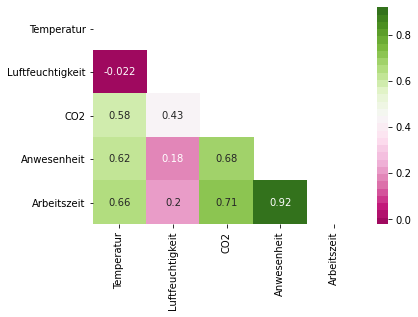

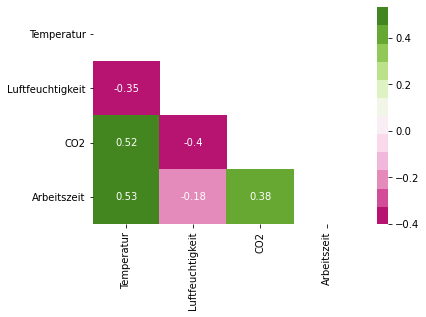

In [5]:
from seaborn import heatmap, color_palette
heatmap(df.corr(),annot=True,cmap=color_palette("PiYG", 30),mask=np.triu(df.corr()))
plt.show()
heatmap(df_test.corr(),annot=True,cmap=color_palette("PiYG", 12),mask=np.triu(df_test.corr()))
plt.show()
#Negativer statt positiver Zusammenhang für Luftfeuchtigkeit und CO2 bei den echten Testdaten!

## **1.2. Funktionen fürs Training** <a class="anchor" id="1.2."></a>


[Inhaltsverzeichnis](#0)

In [73]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, plot_roc_curve,roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC

cv = KFold()
label = "Anwesenheit"

def report(m):
    '''Gibt den den Classification Report auf den Trainings- und Testdaten aus'''
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train),digits=3))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))

def reportScores(m):
    '''Gibt verschiedene Metriken als Kreuzvalidierung'''
    print(f"Cross Value Score Precision: {cross_val_score(m, scaler.fit_transform(X), y, scoring='precision', cv = cv).mean()}")
    print(f"Cross Value Score Recall: {cross_val_score(m, scaler.fit_transform(X), y, scoring='recall', cv=cv).mean()}")
    print(f"Cross Value Score F1: {cross_val_score(m, scaler.fit_transform(X), y, scoring='f1', cv=cv).mean()}")    
    
def test_viz(m):
    '''Plottet die vorhergesagte Anwesenheit auf den echten Testdaten'''
    if 'Anwesenheit' in df_test:
        df_test.drop(columns="Anwesenheit",inplace=True)
    df_test["Anwesenheit"] = m.predict(df_test)
    px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
    df_test.drop(columns="Anwesenheit",inplace=True)



# **2. Simple Modelle** <a class="anchor" id="2."></a>


[Inhaltsverzeichnis](#0)

## **2.1. Logistische Regression Einfach** <a class="anchor" id="2.1."></a>


[Inhaltsverzeichnis](#0)

In [7]:
# Erstellung eines einfachen Dataframes zum testen der ersten Modelle
df_e = df.drop(['Arbeitszeit'], axis = 1).reset_index()
df_e['Stunde'] = df_e.Datum.dt.hour
df_e['Wochenende'] = df_e.Datum.dt.day_of_week >= 5
X = df_e.drop(['Datum'], axis=1,inplace=True)

df_e.head()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Stunde,Wochenende
0,23.18,27.2720,721.25,1,17,False
1,23.15,27.2675,714.00,1,17,False
2,23.15,27.2450,713.50,1,17,False
3,23.15,27.2000,708.25,1,17,False
4,23.10,27.2000,704.50,1,17,False


In [8]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

print('Trainingsdaten:\n', classification_report(y_train, model.predict(X_train)))
print('Testdaten:\n', classification_report(y_test, model.predict(X_test)))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      7268
           1       0.87      0.83      0.85      2261

    accuracy                           0.93      9529
   macro avg       0.91      0.90      0.90      9529
weighted avg       0.93      0.93      0.93      9529

Testdaten:
               precision    recall  f1-score   support

           0       0.76      0.97      0.86      2047
           1       0.90      0.45      0.60      1130

    accuracy                           0.79      3177
   macro avg       0.83      0.71      0.73      3177
weighted avg       0.81      0.79      0.77      3177



### **2.1.1. Verbesserung der LR mit Hyperparametertuning** <a class="anchor" id="2.1.1."></a>


[Inhaltsverzeichnis](#0)

Hyperparameter:
- Solver: Algorithmus zur Optimierung des Problems
- C: Maß der Regularisierung

In [ ]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
cv = KFold()

lr = linear_model.LogisticRegression()
grid = {
"solver" : ["lbfgs","newton-cg"],
"C": [ 1.0, 0.1, 10]
}

clf = GridSearchCV(lr, grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
reportScores(clf)

In [ ]:
# Model mit den empfohlenen Hyperparametern
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

# Generierung der Dummy-Variablen aus Stunde
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eLR = linear_model.LogisticRegression(**clf.best_params_,max_iter=10000)
eLR.fit(X_train, y_train)

report(eLR)

## **2.2. Decision Tree Einfach** <a class="anchor" id="2.2."></a>


[Inhaltsverzeichnis](#0)

In [ ]:
X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit'], axis = 1)
y = df_e['Anwesenheit']
X_name = list(X.columns)

print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

report(model)
plt.figure(figsize=(12,12))
plot_tree(model, rounded=True, filled=True, class_names=[str(0),str(1)], feature_names=X_name, fontsize=10)
plt.show(model)

### **2.2.1. Verbesserung des DT mit Hyperparametertuning** <a class="anchor" id="2.2.1."></a>


[Inhaltsverzeichnis](#0)

Hyperparameter:
- Max Depth: Maximale Tiefe des Baumes
- Criterion: Gütemaß des Splits

In [ ]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

random_grid = {
'max_depth': [2, 3, 5, 10, 20],
'criterion': ["gini", "entropy"]
}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, random_grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
reportScores(clf)

In [ ]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eDT = DecisionTreeClassifier(**clf.best_params_)
eDT.fit(X_train, y_train)

report(eDT)

## **2.3. Random Forest Einfach** <a class="anchor" id="2.3."></a>


[Inhaltsverzeichnis](#0)

In [ ]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
X_name = feature_names=list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

### **2.3.1. Verbesserung des RF mit Hyperparametertuning** <a class="anchor" id="2.3.1."></a>


[Inhaltsverzeichnis](#0)

Hyperparameter:
- Max Features: Anzahl der Features die bei der Suche des besten Splits beachtet werden soll
- n_estimators: Anzahl der Bäume im Wald ;)
- Max Depth: Maximale Tiefe eines Baumes im Wald

In [ ]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
grid = {
"max_features" : ["auto", "sqrt", "log2"],    
"n_estimators" : [10,50,100,200],
'max_depth': [2, 3, 5, 10, 20],
}

clf = GridSearchCV(rf, grid, cv = 5)
clf.fit(X_train, y_train)
print(clf.best_params_)
reportScores(clf)

In [ ]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
X_name = feature_names=list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eRF = RandomForestClassifier(**clf.best_params_,random_state=42)
eRF.fit(X_train, y_train)

report(eRF)

## **2.4. SVC Einfach** <a class="anchor" id="2.4."></a>


[Inhaltsverzeichnis](#0)

In [17]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

#Dummy-Kodierung verbessert die Vorhersagen deutlich
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC()
model.fit(X_train, y_train)

report(model)

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.973     0.980     0.977      6953
           1      0.946     0.927     0.936      2576

    accuracy                          0.966      9529
   macro avg      0.959     0.954     0.957      9529
weighted avg      0.966     0.966     0.966      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.981     0.975     0.978      2362
           1      0.929     0.945     0.937       815

    accuracy                          0.967      3177
   macro avg      0.955     0.960     0.957      3177
weighted avg      0.967     0.967     0.967      3177



### **2.4.1. Verbesserung des SVC mit Hyperparametertuning** <a class="anchor" id="2.4.1."></a>


[Inhaltsverzeichnis](#0)

Hyperparameter:
- C: Gütemaß der Regularisierung
- Kernel: Kerneltyp des Algorithmus

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svc = SVC()
grid = {
"C" : [ 0.1, 1, 10],
"kernel" : ["poly", "rbf", "sigmoid"], 
"degree" : [1, 2, 3]
}

clf = GridSearchCV(svc, grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
reportScores(clf)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eSVC = SVC(**clf.best_params_)
eSVC.fit(X_train, y_train)

report(eSVC)

# **3. Modelle mit Arbeitszeit als Feature** <a class="anchor" id="3."></a>


[Inhaltsverzeichnis](#0)

##### Warum Arbeitszeit?

Da es sich um ein Bürogebäude handelt, ist davon auszugehen dass die Arbeitszeit in den allermeisten Fällen der potentiellen Nutzungszeit des Systems entspricht. Außerhalb dieses Routinebetriebs sollte das Risiko von False Positives minimiert werden und manuelle Benutzung ist zumutbar. Die Mittagspause haben wir ebenfalls gewichtet berücksichtigt.

In [ ]:
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = linear_model.LogisticRegression()
grid = {
"solver" : ["newton-cg", "lbfgs", "sag"],
"C": [100, 10, 1.0, 0.1]
}

rsLR =  GridSearchCV(estimator = lr, param_grid = grid,cv = 5)
rsLR.fit(X_train,y_train)
print(rsLR.best_params_)
reportScores(rsLR)

In [ ]:
mLR = linear_model.LogisticRegression(**rsLR.best_params_)
mLR.fit(X_train, y_train)

report(mLR)
df_test["Anwesenheit"] = mLR.predict(scaler.transform(df_test))
px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
df_test.drop(columns="Anwesenheit",inplace=True)

## **3.2. Decision Tree** <a class="anchor" id="3.2."></a>


[Inhaltsverzeichnis](#0)

In [ ]:
X = df.drop(columns=[label])
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rs = DecisionTreeClassifier(random_state=42)
grid = {
'max_depth': [2, 3, 5, 10, 20],
'criterion': ["gini", "entropy"]
}
rsDT =  GridSearchCV(estimator = rs, param_grid = grid, cv = 5)

rsDT.fit(X_train,y_train)
print(rsDT.best_params_,"\n")
reportScores(rsDT)

In [ ]:
print(pd.DataFrame(columns=df.columns))
X_name = feature_names=list(X.columns)
mDT = DecisionTreeClassifier(**rsDT.best_params_,random_state=42)
mDT.fit(X_train, y_train)

report(mDT)
plt.figure(figsize=(12,12))
plot_tree(mDT, rounded=True, max_depth=3, filled=True, class_names=[str(0),str(1)], feature_names=X_name, fontsize=10)
plt.show(mDT)
test_viz(mDT)

## **3.3. Random Forest** <a class="anchor" id="3.3."></a>


[Inhaltsverzeichnis](#0)

In [ ]:
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
grid = {
"max_features" : ["auto", "sqrt", "log2"],    
"n_estimators" : [10,50,100,200],
'max_depth': [2, 3, 5, 10, 20],
}

rsRF =  GridSearchCV(estimator = rf, param_grid = grid,cv = 5)
rsRF.fit(X_train,y_train)
print(rsRF.best_params_)
reportScores(rsRF)

In [ ]:
print(pd.DataFrame(columns=df.columns))
mRF = RandomForestClassifier(**rsRF.best_params_)
mRF.fit(X_train, y_train)

report(mRF)
test_viz(mRF)

## **3.4. SVC** <a class="anchor" id="3.4."></a>


[Inhaltsverzeichnis](#0)

In [ ]:
X = df.drop(columns=[label])
y = df[label]
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(random_state=42)
grid = {
"C" : [ 0.1, 1, 10],    
"kernel" : ["poly", "rbf", "sigmoid"], 
"degree" : [1,2,3]
}

rsSV = GridSearchCV(svc, grid, cv = 5)
rsSV.fit(X_train, y_train)
print(rsSV.best_params_)
reportScores(rsSV)

In [ ]:
mSVC = SVC(**rsSV.best_params_)
mSVC.fit(X_train, y_train)

report(mSVC)
df_test["Anwesenheit"] = mSVC.predict(scaler.transform(df_test))
px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
df_test.drop(columns="Anwesenheit",inplace=True)

# **4. Analyse** <a class="anchor" id="4."></a>


[Inhaltsverzeichnis](#0)

## **4.1. ROC-Kurve** <a class="anchor" id="4.1."></a>


[Inhaltsverzeichnis](#0)

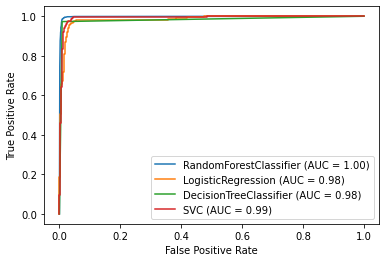

In [28]:
classifiers = [mRF,mLR,mDT,mSVC]
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=plt.gca())

#Alle Kurven sind generell sehr gut, nur in Details unterscheiden sie sich. 
#Der Random Forest scheint aber zumindest nach dieser Metrik noch am besten zu sein

### **4.1.1 Gemittelte Vorhersage aller Modelle auf den unbekannten Testdaten** <a class="anchor" id="4.1.1."></a>


[Inhaltsverzeichnis](#0)

In [43]:
df_temp = pd.DataFrame(df_test.index,index=df_test.index)
df_temp["Anwesenheit"] = (mRF.predict(df_test) + mLR.predict(scaler.fit_transform(df_test)) + mDT.predict(df_test) + mSVC.predict(scaler.fit_transform(df_test)))/4
px.bar(df_test.resample("10min").mean(),y="CO2",color=df_temp.resample("10min").mean()["Anwesenheit"])

## **4.2. Kostenrechnung** <a class="anchor" id="4.2."></a>


[Inhaltsverzeichnis](#0)

### **4.2.1. Berechnung der Kosten der einfachen Modellen** <a class="anchor" id="4.2.1."></a>


[Inhaltsverzeichnis](#0)

Annahme: Büro mit Luftwärmepumpe, die entsprechend schnell das Raumklima verändert. Daher haben wir auf Minutenebene die Kosten berechnet.

In [30]:
def get_cost(value):
    if value == 0:
        return 0

    else:
        return 1/12

models = {eLR:"logistischer Regression",eDT:"Decision Tree",eRF:"Random Forest",eSVC:"SVM"}
for model, modelName in models.items():
    #Vorbereitung eines Dataframes welcher benutzt wird um die Anzahl an falschen Minuten
    #sowie die Kosten für die Zeit zu ermitteln.
    data = pd.read_csv('train.csv')
    data = data[['Datum','Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Anwesenheit']]
    data['Datum'] = pd.to_datetime(data['Datum'])
    data["Stunde"] = data["Datum"].dt.hour
    data["Wochenende"] = data["Datum"].dt.day_of_week >= 5
    if model in [eLR, eSVC]:
        data = pd.get_dummies(data, columns=['Stunde'])
    data = data.set_index('Datum')
    data.dropna(inplace=True)
    data['Anwesenheit_pred'] = model.predict(MinMaxScaler().fit_transform(data.drop(["Anwesenheit"],axis=1)))
    data['Anwesenheit_false'] = (data.Anwesenheit != data.Anwesenheit_pred) & (data.Anwesenheit == 1)

    data_h = data[['Anwesenheit_pred']].copy()
    data_h['Kosten'] = data_h['Anwesenheit_pred'].apply(get_cost)
    print(f"Die Kosten betragen bei {modelName}: {data_h['Kosten'].sum().round(2)}€")
    fehler_tag = data[['Anwesenheit_false']].resample('d').sum()
    print(f"Durchschnittliche falsche Minuten pro Tag: {round(fehler_tag[['Anwesenheit_false']].mean()[0])}\n")

Die Kosten betragen bei logistischer Regression: 326.92€
Durchschnittliche falsche Minuten pro Tag: 20.0

Die Kosten betragen bei Decision Tree: 339.17€
Durchschnittliche falsche Minuten pro Tag: 7.0

Die Kosten betragen bei Random Forest: 336.0€
Durchschnittliche falsche Minuten pro Tag: 5.0

Die Kosten betragen bei SVM: 331.0€
Durchschnittliche falsche Minuten pro Tag: 19.0



### **4.2.2. Berechnung der Kosten der Modelle mit Arbeitszeit** <a class="anchor" id="4.2.2."></a>


[Inhaltsverzeichnis](#0)

In [31]:
def get_cost(value):
    if value == 0:
        return 0

    else:
        return 1/12

models = {mLR:"logistischer Regression",mDT:"Decision Tree",mRF:"Random Forest",mSVC:"SVM"}
for model, modelName in models.items():
    data = pd.read_csv('train.csv')
    data = data[['Datum','Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Anwesenheit']]
    data['Datum'] = pd.to_datetime(data['Datum'])
    data["Arbeitszeit"] = (data["Datum"].dt.hour.between(8,17))&(data["Datum"].dt.dayofweek < 5)&~((data["Datum"].dt.hour==13)&(data["Datum"].dt.minute.between(0,15)))
    data = data.set_index('Datum')
    data.dropna(inplace=True)
    data['Anwesenheit_pred'] = model.predict(MinMaxScaler().fit_transform(data.drop(["Anwesenheit"],axis=1)))
    data['Anwesenheit_false'] = (data.Anwesenheit != data.Anwesenheit_pred) & (data.Anwesenheit == 1)

    data_h = data[['Anwesenheit_pred']].copy()
    data_h['Kosten'] = data_h['Anwesenheit_pred'].apply(get_cost)
    print(f"Die Kosten betragen bei {modelName}: {data_h['Kosten'].sum().round(2)}€")
    fehler_tag = data[['Anwesenheit_false']].resample('d').sum()
    print(f"Durchschnittliche falsche Minuten pro Tag: {round(fehler_tag[['Anwesenheit_false']].mean()[0])}\n")


Die Kosten betragen bei logistischer Regression: 347.25€
Durchschnittliche falsche Minuten pro Tag: 13.0

Die Kosten betragen bei Decision Tree: 353.58€
Durchschnittliche falsche Minuten pro Tag: 24.0

Die Kosten betragen bei Random Forest: 356.33€
Durchschnittliche falsche Minuten pro Tag: 11.0

Die Kosten betragen bei SVM: 336.67€
Durchschnittliche falsche Minuten pro Tag: 15.0



### **4.2.3. Optimierung der Kosten** <a class="anchor" id="4.2.3."></a>


[Inhaltsverzeichnis](#0)

Da 60 unbeheizte Minuten im täglichen Mittel toleriert werden, reizen wir die Nerven der Angestellten effizient aus um die Kosten weiter zu senken. 📈 

Versucht haben wir dies mit Anpassen der Gewichtung.

In [32]:
def calculate_cost(models):
    for model, modelName in models.items():
        data = pd.read_csv('train.csv')
        data = data[['Datum','Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Anwesenheit']]
        data['Datum'] = pd.to_datetime(data['Datum'])
        data["Arbeitszeit"] = (data["Datum"].dt.hour.between(8,17))&(data["Datum"].dt.dayofweek < 5)&~((data["Datum"].dt.hour==13)&(data["Datum"].dt.minute.between(0,15)))
        data = data.set_index('Datum')
        data.dropna(inplace=True)
        data['Anwesenheit_pred'] = model.predict(MinMaxScaler().fit_transform(data.drop(["Anwesenheit"],axis=1))) 
        data['Anwesenheit_false'] = (data.Anwesenheit != data.Anwesenheit_pred) & (data.Anwesenheit == 1)

        data_h = data[['Anwesenheit_pred']].copy()
        data_h['Kosten'] = data_h['Anwesenheit_pred'].apply(get_cost)
        print(f"Die Kosten betragen bei {modelName}: {data_h['Kosten'].sum().round(2)}€")
        fehler_tag = data[['Anwesenheit_false']].resample('d').sum()
        print(f"Durchschnittliche falsche Minuten pro Tag: {round(fehler_tag[['Anwesenheit_false']].mean()[0])}\n")

def get_cost(value):
    if value == 0:
        return 0

    else:
        return 1/12

In [33]:
X = df.drop(columns=[label])
y = df[label]
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

weight = {0:20, 1:1}
svc = SVC(random_state=42, class_weight=weight)
grid = {
"C" : [ 0.1, 1, 10],    
"kernel" : ["poly", "rbf", "sigmoid"], 
"degree" : [1,2,3]
}

rsSV = GridSearchCV(svc, grid, cv = 5)
rsSV.fit(X_train, y_train)
print(rsSV.best_params_)
print(rsSV.score(X_test, y_test))
mSVC = SVC(**rsSV.best_params_, class_weight=weight)
mSVC.fit(X_train, y_train)

models = {mSVC:"Support Vector Machines"}
calculate_cost(models)

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Arbeitszeit'], dtype='object')
{'C': 10, 'degree': 1, 'kernel': 'rbf'}
0.9474346868114574
Die Kosten betragen bei Support Vector Machines: 277.08€
Durchschnittliche falsche Minuten pro Tag: 52.0



In [34]:
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

weight = {0:297, 1:16}
rf = RandomForestClassifier(random_state=42, class_weight=weight)
grid = {
"max_features" : ["auto", "sqrt", "log2"],    
"n_estimators" : [10,50,100,200],
'max_depth': [2, 3, 5, 10, 20],
}

rsRF =  GridSearchCV(estimator = rf, param_grid = grid,cv = 5, scoring = 'precision')
rsRF.fit(X_train,y_train)
print(rsRF.best_params_,"\n",rsRF.score(X_test, y_test))
print(pd.DataFrame(columns=df.columns))
mRF = RandomForestClassifier(**rsRF.best_params_, class_weight=weight)
mRF.fit(X_train, y_train)

models = {mRF:"Random Forest"}
calculate_cost(models)

{'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100} 
 0.9864341085271318
Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Die Kosten betragen bei Random Forest: 305.92€
Durchschnittliche falsche Minuten pro Tag: 33.0



In [40]:
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

weight = {0:19, 1:2}
lr = linear_model.LogisticRegression(class_weight=weight,max_iter=10000)
grid = {
"solver" : ["newton-cg", "lbfgs", "sag"],
"C": [100, 10, 1.0, 0.1]
}

rsLR =  GridSearchCV(estimator = lr, param_grid = grid,cv = 5)
rsLR.fit(X_train,y_train)
print(rsLR.best_params_,"\n",rsLR.score(X_test, y_test))
mLR = linear_model.LogisticRegression(**rsLR.best_params_, class_weight = weight)
mLR.fit(X_train, y_train)

models = {mLR:"Logistische Regression"}
calculate_cost(models)

C:\Users\Gurr\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Gurr\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Gurr\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Gurr\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Gurr\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Gurr\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Gurr\anaconda3\lib\

{'C': 0.1, 'solver': 'newton-cg'} 
 0.9316965690903368
Die Kosten betragen bei Logistische Regression: 278.25€
Durchschnittliche falsche Minuten pro Tag: 59.0



In [ ]:
!git commit -a -m "Fast fertig"